<a href="https://colab.research.google.com/github/pamudithasandaru/Eye_Disease_Prediction/blob/main/Eye_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
base_dir = "/content/drive/MyDrive/Machine_Learning/OCT"

train_dir = base_dir + "/train"
val_dir = base_dir + "/val"
test_dir = base_dir + "/test"

# Create datasets
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),   # resize images for your model input
    batch_size=32,
    label_mode='categorical' # or 'int' if you prefer integer labels
)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

# Optional: improve performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Mounted at /content/drive
Found 1074 files belonging to 4 classes.
Found 1000 files belonging to 4 classes.
Found 1013 files belonging to 4 classes.


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory

In [3]:
from google.colab import drive
from tensorflow.keras.utils import image_dataset_from_directory

# 1️⃣ Mount Google Drive
drive.mount('/content/drive')

# 2️⃣ Define base directory paths
base_dir = "/content/drive/MyDrive/Machine_Learning/OCT"
train_path = base_dir + "/train"
val_path = base_dir + "/val"

# 3️⃣ Load training and validation datasets
training_set = image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=20,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

validation_set = image_dataset_from_directory(
    val_path,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=20,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

# 4️⃣ Optional: Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1074 files belonging to 4 classes.
Found 1000 files belonging to 4 classes.


In [4]:
training_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [5]:
INPUT_SHAPE = (224, 224, 3)

In [6]:
# Load dataset first
raw_train = image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=20,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

# Save class names before prefetching
class_names = raw_train.class_names
num_classes = len(class_names)
print("Detected classes:", class_names)

# Then optimize performance
AUTOTUNE = tf.data.AUTOTUNE
training_set = raw_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


Found 1074 files belonging to 4 classes.
Detected classes: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


In [7]:
mobnet = tf.keras.applications.MobileNetV3Large(
    input_shape=INPUT_SHAPE,
    alpha=1.0,
    minimalistic=False,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
    #name="MobileNetV3Large",
)

22661472/22661472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [8]:
model = tf.keras.models.Sequential()

In [9]:
model.add(tf.keras.Input(shape=INPUT_SHAPE))

In [10]:
model.add(mobnet)

In [11]:
model.add(tf.keras.layers.Dense(units = 4, activation="softmax"))

In [12]:
import tensorflow as tf

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + 1e-7))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# ✅ Usage:
metrics_list = ["accuracy", F1Score()]


In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=metrics_list)

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 1000)           │     5,507,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         4,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,511,436 (21.02 MB)

 Trainable params: 5,487,036 (20.93 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [15]:
# training_history = model.fit(x=training_set,validation_data=validation_set,epochs=15)

In [16]:
training_history = model.fit(x=training_set,validation_data=validation_set,epochs=15)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 843s 8s/step - accuracy: 0.4378 - f1_score: 0.0000e+00 - loss: 1.3820 - val_accuracy: 0.4120 - val_f1_score: 0.0000e+00 - val_loss: 1.3733
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.8701 - f1_score: 0.0000e+00 - loss: 1.3297 - val_accuracy: 0.6350 - val_f1_score: 0.0000e+00 - val_loss: 1.3472
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9609 - f1_score: 0.0000e+00 - loss: 1.3097 - val_accuracy: 0.6030 - val_f1_score: 0.0000e+00 - val_loss: 1.3448
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9804 - f1_score: 0.0000e+00 - loss: 1.2981 - val_accuracy: 0.5910 - val_f1_score: 0.0000e+00 - val_loss: 1.3417
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9865 - f1_score: 0.0000e+00 - loss: 1.2892 - val_accuracy: 0.5920 - val_f1_score: 0.0000e+00 - val_loss: 1.3375
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9938 - f1_score: 0.0000e+00 - loss: 1.2801 - val_a

In [17]:
model.save("./Trained_Eye_disease_model.h5")

In [18]:
model.save("./Trained_Eye_disease_model.keras")

In [19]:
import pickle
with open("Training_history.pkl","wb") as f:
    pickle.dump(training_history.history, f)

In [20]:
import pickle
with open("Training_history.pkl","rb") as f:
    load_history = pickle.load(f)
print(load_history)

{'accuracy': [0.5968342423439026, 0.8966480493545532, 0.9608938694000244, 0.9813780188560486, 0.9916201233863831, 0.9925512075424194, 0.9934822916984558, 0.9934822916984558, 0.994413435459137, 0.994413435459137, 0.994413435459137, 0.994413435459137, 0.994413435459137, 0.994413435459137, 0.994413435459137], 'f1_score': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'loss': [1.371812105178833, 1.3235126733779907, 1.307008147239685, 1.2964003086090088, 1.2864675521850586, 1.2779008150100708, 1.269623875617981, 1.2617710828781128, 1.2538378238677979, 1.246178388595581, 1.2386246919631958, 1.2312010526657104, 1.2237845659255981, 1.21651291847229, 1.2092267274856567], 'val_accuracy': [0.41200000047683716, 0.6349999904632568, 0.6029999852180481, 0.5910000205039978, 0.5920000076293945, 0.6359999775886536, 0.7390000224113464, 0.7279999852180481, 0.7120000123977661, 0.7149999737739563, 0.7210000157356262, 0.7310000061988831, 0.7360000014305115, 0.7400000095367432, 0

In [21]:
print(load_history.keys())

dict_keys(['accuracy', 'f1_score', 'loss', 'val_accuracy', 'val_f1_score', 'val_loss'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


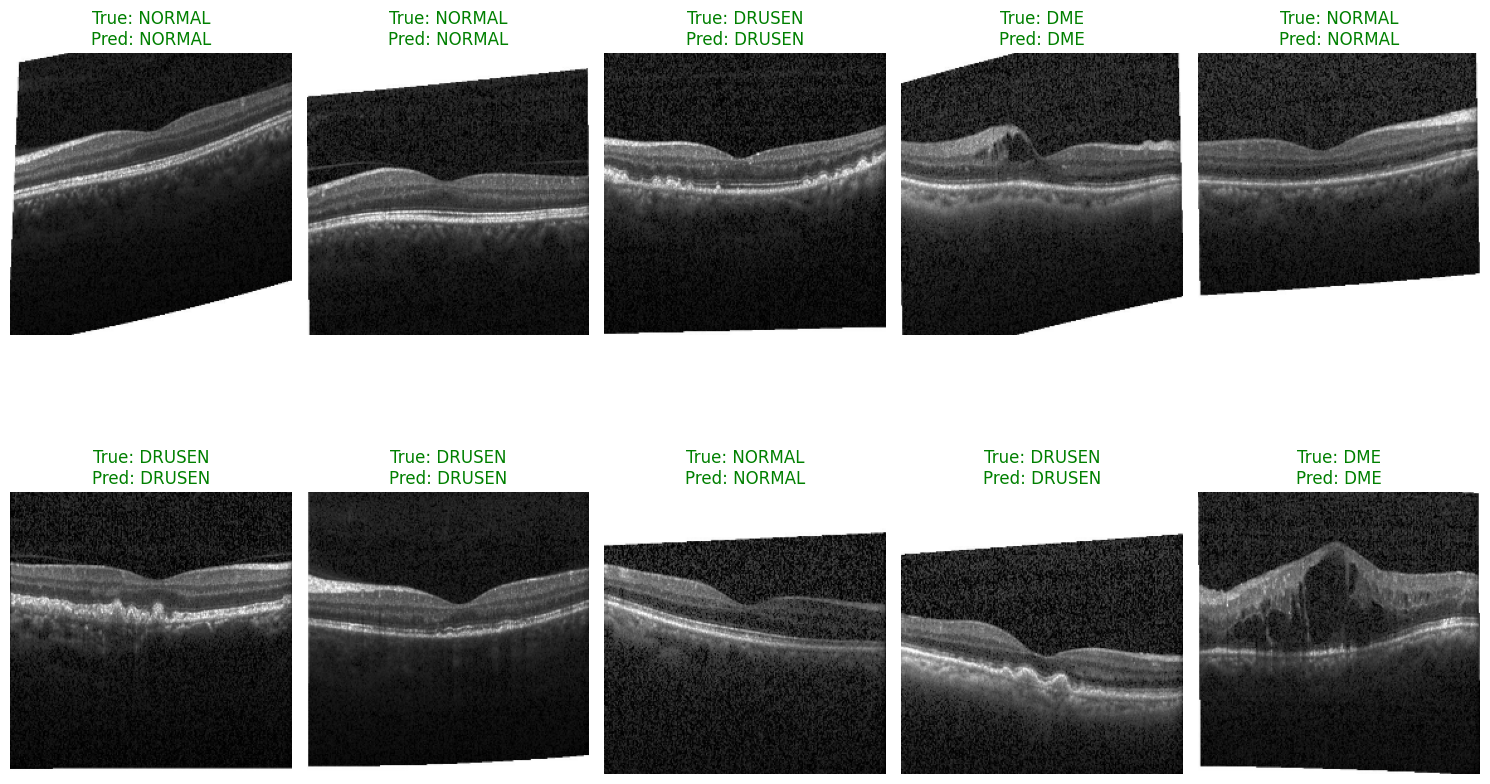

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Get one batch from the test dataset
for images, labels in test_ds.take(1):
    break

# Take the first 10 images and labels from the batch
num_images_to_show = 10
first_10_images = images[:num_images_to_show]
first_10_true_labels = labels[:num_images_to_show]

# Make predictions
predictions = model.predict(first_10_images)

# Convert one-hot encoded labels to class names
true_classes = [class_names[np.argmax(label)] for label in first_10_true_labels]
predicted_classes = [class_names[np.argmax(pred)] for pred in predictions]

# Plot the images with their true and predicted labels
plt.figure(figsize=(15, 10))
for i in range(num_images_to_show):
    plt.subplot(2, 5, i + 1)
    plt.imshow(first_10_images[i].numpy().astype("uint8"))
    color = "green" if true_classes[i] == predicted_classes[i] else "red"
    plt.title(f"True: {true_classes[i]}\nPred: {predicted_classes[i]}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
print("Evaluating model on the test set...")
results = model.evaluate(test_ds)

print("\nTest Loss: {:.4f}".format(results[0]))
print("Test Accuracy: {:.4f}".format(results[1]))
print("Test F1-Score: {:.4f}".format(results[2]))

In [24]:
def predict_image_class_api(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=INPUT_SHAPE[:2])
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0) # Add batch dimension

    # The MobileNetV3Large model with include_preprocessing=True handles normalization internally

    pred = model.predict(x)

    result_index = np.argmax(pred)
    predicted_class = class_names[result_index]

    return predicted_class, pred

# Example usage:
# Make sure to replace this with an actual path to one of your test images
# For example, you can use one from the test dataset's structure.
# You might need to adjust the path based on where your test images are stored.
# For demonstration, let's try to predict for a sample image path.
# This path is hypothetical, you'll need to use a real one from your mounted drive.

# NOTE: You'll need to provide a valid path to an image file.
# For instance, if you have a test image at '/content/drive/MyDrive/Machine_Learning/OCT/test/DRUSEN/some_drusen_image.jpeg'
# replace the placeholder below with your actual image path.

try:
    # Using a hypothetical path, please change this to an actual image path you want to test
    sample_image_path = "/content/drive/MyDrive/Machine_Learning/OCT/test/DRUSEN/DRUSEN-11129-1.jpeg" # Example path

    # Verify if the file exists before trying to predict
    import os
    if os.path.exists(sample_image_path):
        predicted_class, raw_prediction = predict_image_class_api(sample_image_path)
        print(f"Prediction successful for {sample_image_path}:")
        print(f"  Predicted Class: {predicted_class}")
        print(f"  Raw Prediction: {raw_prediction}")
    else:
        print(f"Error: Image file not found at {sample_image_path}. Please provide a valid path.")
except Exception as e:
    print(f"An error occurred during prediction: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Prediction successful for /content/drive/MyDrive/Machine_Learning/OCT/test/DRUSEN/DRUSEN-11129-1.jpeg:
  Predicted Class: DRUSEN
  Raw Prediction: [[0.22645813 0.24047203 0.3009639  0.23210596]]
